<a href="https://colab.research.google.com/github/SuRak35/Causal_Inference__ISI-Kolkata/blob/main/Multi_investment_attribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


Import the necessary libraries


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor, XGBClassifier
from econml.dr import LinearDRLearner
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Improt the sample multi-attribution data

In [ ]:
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
multi_data = pd.read_csv(file_url)

Data Sample

In [ ]:
multi_data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


Define estimator input

In [ ]:

T_bin = multi_data[
    ["Tech Support", "Discount"]
]
Y = multi_data["Revenue"]
X = multi_data[["Size"]]
W = multi_data.drop(
    columns=["Tech Support", "Discount", "Revenue", "Size"]
)

Average customer size per incentive combinatio

In [ ]:
multi_data[["Size", "Tech Support", "Discount"]].groupby(
    by=["Tech Support", "Discount"], as_index=False
).mean().astype(int)

,Tech Support,Discount,Size
0,0,0,70943
1,0,1,96466
2,1,0,108978
3,1,1,171466


In [ ]:
# Define underlying treatment effect function
def TE_fn(X):
    return np.hstack([5000 + 2 / 100 * X, 5 / 100 * X])
true_TE = TE_fn(X)


Define True

In [ ]:
true_coefs = [2 / 100, 5 / 100, 7 / 100]
true_intercepts = [5000, 0, 5000]
treatment_names = ["Tech Support", "Discount", "Tech Support & Discount"]

In [ ]:
# Transform T to one-dimensional array with consecutive integer encoding
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))


T = np.apply_along_axis(treat_map, 1, T_bin).astype(int)

In [ ]:
# Train EconML model with generic helper models
model = LinearDRLearner(
    model_regression=XGBRegressor(learning_rate=0.1, max_depth=3),
    model_propensity=XGBClassifier(learning_rate=0.1, max_depth=3, objective="multi:softprob"),
    random_state=1,
)
# Specify final stage inference type and fit model
model.fit(Y=Y, T=T, X=X, W=W, inference="statsmodels")

In [ ]:
for i in range(model._d_t[0]):
    print(f"Investment: {treatment_names[i]}")
    print(f"True treatment effect: {true_intercepts[i]} + {true_coefs[i]}*Size")
    display(model.summary(T=i + 1))

Investment: Tech Support
True treatment effect: 5000 + 0.02*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.018,0.01,1.734,0.083,-0.002,0.038
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5529.309,734.905,7.524,0.0,4088.922,6969.696


Investment: Discount
True treatment effect: 0 + 0.05*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.048,0.01,4.632,0.0,0.027,0.068
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,647.327,736.703,0.879,0.38,-796.583,2091.238


Investment: Tech Support & Discount
True treatment effect: 5000 + 0.07*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.071,0.01,6.944,0.0,0.051,0.091
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5081.263,742.96,6.839,0.0,3625.088,6537.438


In [ ]:
# Compare learned coefficients with true model coefficients
# Aggregate data
coef_indices = np.arange(model._d_t[0])
coefs = np.hstack([model.coef_(T=i) for i in 1 + coef_indices])
intercepts = np.hstack([model.intercept_(T=i) for i in 1 + coef_indices])

# Calculate coefficient error bars for 95% confidence interval
coef_error = np.hstack([model.coef__interval(T=i) for i in 1 + coef_indices])
coef_error[0, :] = coefs - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - coefs

# Calculate intercept error bars for 95% confidence interval
intercept_error = np.vstack(
    [model.intercept__interval(T=i) for i in 1 + coef_indices]
).T
intercept_error[0, :] = intercepts - intercept_error[0, :]
intercept_error[1, :] = intercept_error[1, :] - intercepts

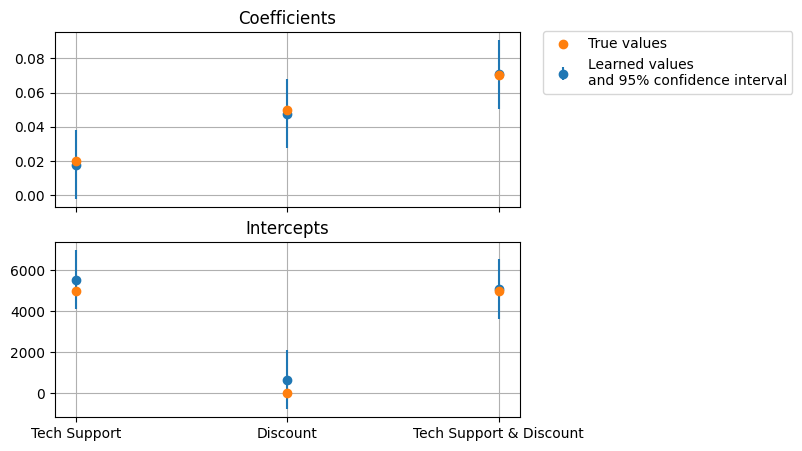

In [ ]:
# Plot coefficients
plt.figure(figsize=(6, 5))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(
    coef_indices,
    coefs,
    coef_error,
    fmt="o",
    label="Learned values\nand 95% confidence interval",
)
plt.scatter(coef_indices, true_coefs, color="C1", label="True values", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients")
plt.legend(loc=(1.05, 0.65))
plt.grid()

# Plot intercepts
plt.subplot(2, 1, 2)
plt.errorbar(coef_indices, intercepts, intercept_error, fmt="o")
plt.scatter(coef_indices, true_intercepts, color="C1", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.title("Intercepts")
plt.grid()
plt.show()

In [ ]:
# Define cost function
def cost_fn(multi_data):
    t1_cost = multi_data[["PC Count"]].values * 100
    t2_cost = np.ones((multi_data.shape[0], 1)) * 7000
    return np.hstack([t1_cost, t2_cost, t1_cost + t2_cost])

In [ ]:
# Get roi for each customer and possible treatment
potential_roi = model.const_marginal_effect(X=X.values) - cost_fn(multi_data)
# Add a column of 0s for no treatment
potential_roi = np.hstack([np.zeros((X.shape[0], 1)), potential_roi])

In [ ]:
all_treatments = np.array(["None"] + treatment_names)
recommended_T = np.argmax(potential_roi, axis=1)

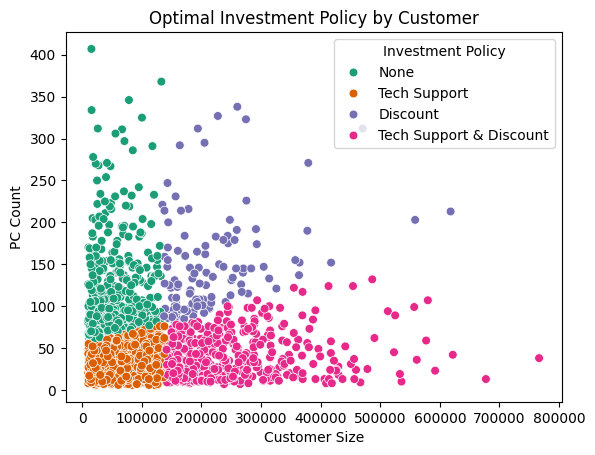

In [ ]:
ax1 = sns.scatterplot(
    x=X.iloc[:, 0].values.flatten(),
    y=multi_data["PC Count"].values,
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    palette="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="Customer Size",
    ylabel="PC Count",
    title="Optimal Investment Policy by Customer",
)
plt.show()

In [ ]:
roi_current = potential_roi[np.arange(X.shape[0]), T].sum()
roi_optimal = potential_roi[np.arange(X.shape[0]), recommended_T].sum()
roi_bothT = potential_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - model.effect(X=X.values, T1=T)).sum()

In [ ]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,9.438194e+06,60.9
1,Current,2.262213e+06,14.6
2,All Investments,6.687996e+05,4.3


In [ ]:
true_roi = np.zeros((X.shape[0], 4))
true_roi[:, 1:3] = TE_fn(X.iloc[:, [0]])
true_roi[:, 3] = np.sum(true_roi[:, 1:3], axis=1)
true_roi[:, 1:] -= cost_fn(multi_data)

In [ ]:
roi_current = true_roi[np.arange(X.shape[0]), T].sum()
roi_optimal = true_roi[np.arange(X.shape[0]), recommended_T].sum()
roi_bothT = true_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - model.effect(X=X.values, T1=T)).sum()

In [ ]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,8918302.87,57.6
1,Current,1829938.41,11.8
2,All Investments,373176.80,2.4


In [ ]:
from econml.policy import DRPolicyForest

X = multi_data[['Size', 'PC Count']]
est = DRPolicyForest(random_state=1,
                     min_propensity=1e-3,
                     min_impurity_decrease=0.1,
                     min_samples_leaf=40,
                     max_samples=.6,
                     honest=True,
                     max_depth=4)
costs = np.hstack([np.zeros((X.shape[0], 1)), cost_fn(multi_data)])
est.fit(Y - costs[np.arange(X.shape[0]), T], T, X=X)
recommended_T = est.predict(X.values)

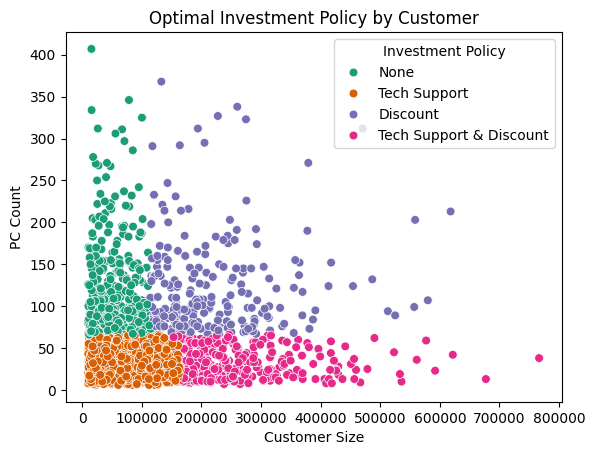

In [ ]:
ax1 = sns.scatterplot(
    x=X.iloc[:, 0].values.flatten(),
    y=multi_data["PC Count"].values,
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    palette="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="Customer Size",
    ylabel="PC Count",
    title="Optimal Investment Policy by Customer",
)
plt.show()

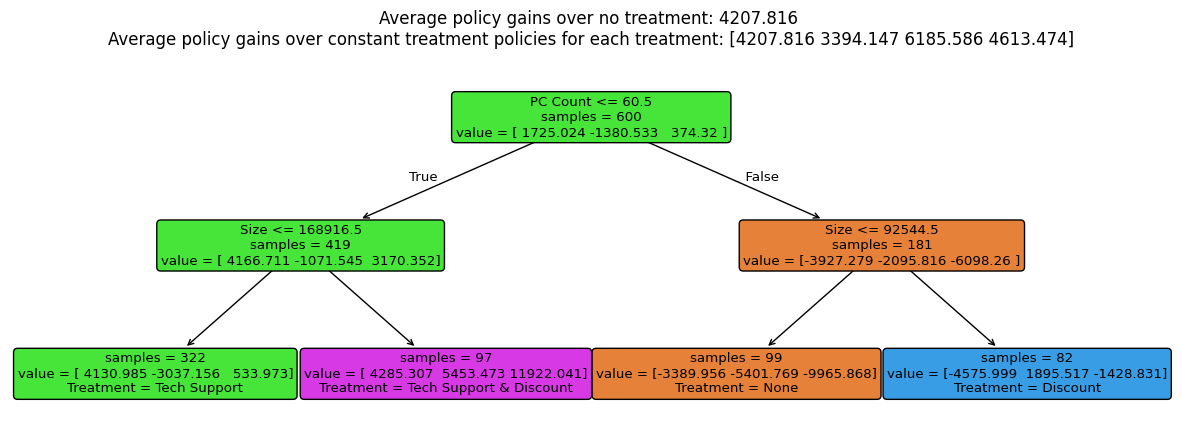

In [ ]:
plt.figure(figsize=(15, 5))
est.plot(0, max_depth=2, treatment_names=['None'] + treatment_names)

In [ ]:
roi_current = true_roi[np.arange(X.shape[0]), T].sum()
roi_optimal = true_roi[np.arange(X.shape[0]), recommended_T].sum()
roi_bothT = true_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - model.effect(X=X.values[:, [0]], T1=T)).sum()

In [ ]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,8657235.58,55.9
1,Current,1829938.41,11.8
2,All Investments,373176.80,2.4
